# Evaluating Model Performance for Numerical Data

### Excercise: Comparing Model Performance
Load a dataset of choice, ameanible to linear regression analysis. You can use the data from the last workshop. Split the data into train - validation - and test. 

In [99]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Change the current working directory
os.chdir('/Users/Sari/Documents/Code/Semester 4 workbooks')

In [100]:
df = pd.read_csv('data/clean_tree_data.csv')
print(df.columns)
df.drop('Unnamed: 0', axis=1, inplace=True)


Index(['Unnamed: 0', 'growth_ground', 'tree_height', 'tree_admin',
       'tree_municipality', 'age', 'species', 'species_group',
       'tree_treatment', 'Naam_buurt', 'Naam_wijk',
       'parked_cars_in_neighbourhood'],
      dtype='object')


In [101]:
# categorical variables
categorical_vars = ['growth_ground', 'tree_admin', 'tree_municipality',
                    'species', 'species_group', 'tree_treatment', 'Naam_buurt',
                    'Naam_wijk']

# I want to store the dummies for particular variables so I can include/exclude 
# them in my regression
indexed_dummy_columns = dict()

df_dummies = df

for category in categorical_vars:
    dummies = pd.get_dummies(df[category], prefix=category, drop_first=True)
    dummies = dummies.astype(float)
    indexed_dummy_columns[category] = dummies.columns
    df_dummies = pd.concat([df_dummies, dummies], axis=1)

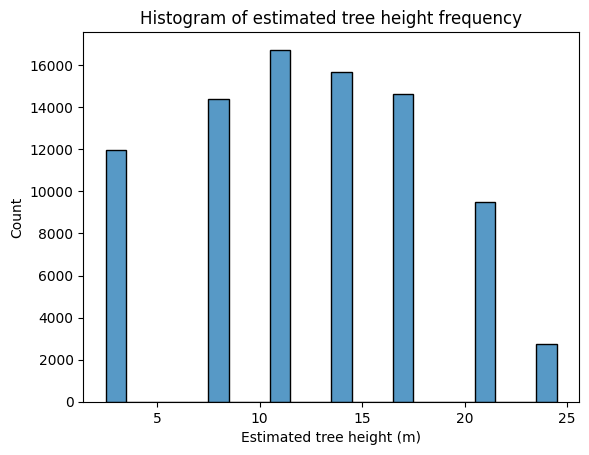

12.119146102075154

In [102]:
# tree height distribution
ax = sns.histplot(df_dummies['tree_height'], discrete=True).set(
    title="Histogram of estimated tree height frequency"
)
plt.xlabel('Estimated tree height (m)')
plt.show()
df_dummies['tree_height'].mean()

Skewed to the left.

### 1a: Split your dataset into three parts, namely training, validation and test. 

In [103]:
# make train, validate, and test sets
suffled_df = df_dummies.sample(frac=1, random_state=31415)

total_size = len(df_dummies.index)
train_size = int(total_size * 0.5)
validation_size = int(total_size * 0.25)

y_variable = 'tree_height'

train_set = suffled_df.iloc[:train_size]
validate_set = suffled_df.iloc[train_size:(train_size + validation_size)]
test_set = suffled_df.iloc[(train_size + validation_size):]

X_train = train_set.drop(y_variable, axis=1)
y_train = train_set[y_variable]

X_train_full = sm.add_constant(X_train)

X_valid = validate_set.drop(y_variable, axis=1)
y_valid = validate_set[y_variable]

X_valid_full = sm.add_constant(X_valid)

X_test = test_set.drop(y_variable, axis=1)
y_test = test_set[y_variable]

X_test_full = sm.add_constant(X_valid)

### 1b:  Compare 3 models on their performance on the validation set

Define 3 models, one `unsaturated` which uses only the intercept; one `fully saturated` which represents the most complex model you can generate, and one in between. Fit each model to the training data, and generate predictions for each model on the test_set. 

In [104]:

def fit_predict_evaluate(X_train, y_train, X_valid, y_valid, credibility_pct=95, n_sims = 10000):
    
    # Fit the model
    model = sm.OLS(y_train, X_train).fit()
    
    # Step 2: Predict new values
    new_predictions = model.predict(X_valid)
    
    # Step 3: Calculate standard errors of the predictions on the validation set
    cov_matrix = model.cov_params()
    design_matrix = X_valid
    variances = np.diag(np.dot(np.dot(design_matrix, cov_matrix), design_matrix.T))
    std_errors_predictions = np.sqrt(variances)
    
    # Generate posterior samples
    new_predictions_array = np.array(new_predictions)[:, None]  
    std_errors_predictions_array = np.array(std_errors_predictions)[:, None]  
    
    predicted_samples = np.random.normal(loc=new_predictions_array,
                                         scale=std_errors_predictions_array,
                                         size=(len(new_predictions), n_sims))
    
    # Calculate estimates summaries
    monte_carlo_medians = np.median(predicted_samples, axis=1)
    prediction_intervals = np.percentile(predicted_samples, [(100-credibility_pct)/2, credibility_pct+(100-credibility_pct)/2], axis=1)
    
    # Calculate metrics
    bias = np.mean(monte_carlo_medians - y_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, monte_carlo_medians))
    correlation = np.corrcoef(y_valid, monte_carlo_medians)[0, 1]
    coverage = np.mean((y_valid >=  prediction_intervals[0,:]) & (y_valid <=  prediction_intervals[1,:]))
    
    # Return results as a dictionary
    results = {
        'bias': bias,
        'rmse': rmse,
        'correlation': correlation,
        'coverage': coverage,
        'predictions': new_predictions,
        'prediction_intervals': prediction_intervals
    }

    return results

In [105]:
score_intercept = fit_predict_evaluate(
    X_train_full[['const']],
    y_train,
    X_valid_full[['const']],
    y_valid,
    credibility_pct=95
)

In [106]:
score_intercept

{'bias': 0.019944932278947287,
 'rmse': 5.704070421566986,
 'correlation': -0.005168963607790924,
 'coverage': 0.0,
 'predictions': 20101    12.121109
 3647     12.121109
 35770    12.121109
 83987    12.121109
 82582    12.121109
            ...    
 12603    12.121109
 55602    12.121109
 81225    12.121109
 55851    12.121109
 65370    12.121109
 Length: 21396, dtype: float64,
 'prediction_intervals': array([[12.06624243, 12.06696767, 12.06832848, ..., 12.0675633 ,
         12.06843815, 12.06565293],
        [12.17486375, 12.17494347, 12.17521497, ..., 12.17430636,
         12.17481372, 12.1750395 ]])}

In [107]:
# We normally have a lot of "location based variables" and that's a bit less usable.
# If you want to grow a tree, "grow it in the neighbourhood Weesperzijde" isn't
# very universally applicable
variables_of_interest = [
    'age',
    'const',
    'parked_cars_in_neighbourhood',
]

categories_of_interest = [
    'growth_ground',
    'species',
    'tree_treatment',
    'tree_admin',
]

for category in categories_of_interest:
    for variable in indexed_dummy_columns[category]:
        variables_of_interest.append(variable)

score_applicable = fit_predict_evaluate(
    X_train_full[variables_of_interest],
    y_train,
    X_valid_full[variables_of_interest],
    y_valid,
    credibility_pct=95
)

In [108]:
score_applicable

{'bias': 0.035320792727288976,
 'rmse': 3.2966213138627487,
 'correlation': 0.8161500929362728,
 'coverage': 0.15012151804075527,
 'predictions': 20101    11.623261
 3647      8.481128
 35770    14.309929
 83987    13.873630
 82582     9.648218
            ...    
 12603     5.822755
 55602    16.381565
 81225     8.155557
 55851    22.254366
 65370    17.070964
 Length: 21396, dtype: float64,
 'prediction_intervals': array([[11.16402742,  8.17863163, 14.02340086, ...,  7.84581749,
         21.82396452, 16.7913791 ],
        [12.10206982,  8.77956446, 14.59465923, ...,  8.46019681,
         22.66867786, 17.35234337]])}

In [109]:
score_saturated = fit_predict_evaluate(
    X_train_full, 
    y_train, 
    X_valid_full, 
    y_valid, 
    credibility_pct=95
)


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
score_saturated

NameError: name 'score_saturated' is not defined

In [ ]:
# generate a table with the scores 
scores = [
    {'name': 'Intercept Only', **score_intercept},
    {'name': 'National', **score_applicable},
    {'name': 'Saturated', **score_saturated},
]

# Convert the list of dictionaries to a DataFrame
scores_df_automated = pd.DataFrame(scores)

# Rename the 'name' column to 'Score Type' for clarity
scores_df_automated.rename(columns={'name': 'Score Type'}, inplace=True)

scores_df_automated

NameError: name 'score_saturated' is not defined

### 1c:  Comment on the scores

Can you identify a model to move forward with ? on what grounds ? 
What do the differences in performance over the different metrics tell you about each model's strengths and weaknesses ? 

In [ ]:
train_X_full

### 1d: For your best performning model, estimate the generalisation error 

Generate point-estimates and a measure of uncertainty for each error metric. Hint: the most comprehensive way to do this is to generate error distributions. You can do this by calculating each error metric on a separate set of simulated predictions from the empirical predictive posterior distribution. 

In [ ]:
# Fit the model (best performing was National on the RMSE metric)
model = sm.OLS(train_y, train_X_full[['const','term2', 'real_gdp_pct_growth', 'net_approval']]).fit()
    
# Step 2: Predict new values
new_predictions = ...
    
# Step 3: Calculate standard errors of the predictions
cov_matrix = ...
design_matrix = ...
variances = ...
std_errors_predictions = ...
    
# Generate posterior samples
new_predictions_array = ...
std_errors_predictions_array = ...
    
predicted_samples = np.random.normal(loc=...,
                                     scale=...,
                                     size=(..., ...)) 

In [ ]:
# Calculate metrics
bias_array = ...
rmse_array = ...
correlation_array = ...
# Note: coverage doesn't have a distribution, because it is already a measure which is averaged over simulations. So it is omitted here - we know it from the table above. 
# Combine metrics into a single array where each metric is a column
metrics = {
    'Bias': bias_array,
    'RMSE': rmse_array,
    'Correlation': correlation_array
}


In [ ]:
# plot the distributions of each error metric
import matplotlib.pyplot as plt

# Define metric names
metric_names = ['Bias', 'RMSE', 'Correlation']

# Define number of metrics to plot
n_metrics = len(metric_names)

# Adjust rows and columns calculation to avoid empty subplots
n_plots = n_metrics  # Total number of plots needed
n_rows = 1
n_cols = (n_plots + n_rows - 1) // n_rows  # Calculate columns needed, ensuring we have enough space

# Adjust the figsize if necessary
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), squeeze=False)  # Make sure axes is always a 2D array

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

for i, name in enumerate(metric_names):
    data = metrics[name]  # Access data directly from dictionary
    median_val = np.median(data)
    confidence_interval = np.percentile(data, [2.5, 97.5])
    
    ax = axes_flat[i]
    ax.hist(data, bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=confidence_interval[0], color='orange', linestyle='--', label=f'95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]')
    ax.axvline(x=confidence_interval[1], color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--', label='Zero line')  # Highlight 0 with a line
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    # Ensure plot encompasses 0 by adjusting xlim if necessary
    xlims = ax.get_xlim()
    ax.set_xlim(min(xlims[0], 0), max(xlims[1], 0))

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes_flat[j])

# Adjust layout for better spacing and display the plot
plt.tight_layout()
plt.show()